## The MobilenetV2 model development and fine tuning

in this notebook we will load and add our layers to the base model of the pre-trained MobilenetV2 model, and fine tune the following parameters of the model:

# **Setting up the Environment**

In [ ]:
# Delete All Folder
# import shutil
# shutil.rmtree('/content/Brain Tumor Dataset')
# shutil.rmtree('/content/Brain Tumor Dataset-cropped')
# shutil.rmtree('/content/Brain Tumor Dataset-proccess')
# shutil.rmtree('/content/dataset-testing')
# shutil.rmtree('/content/dataset-testing-cropped')
# shutil.rmtree('/content/dataset-testing-proccess')
# shutil.rmtree('/content/preview')

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook
import time
# import tqdm.gui as tqdm
# import tqdm.notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from tqdm import tqdm
import pickle

import glob
import random
from matplotlib.image import imread
import cv2
import imutils
from pathlib import Path
from keras.metrics import Precision, Recall, AUC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

from tensorflow.keras.layers import Activation, Dense
from tabulate import tabulate
from sklearn.model_selection import StratifiedKFold
from pylab import rcParams

In [ ]:
#Menghubungkan ke google drive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Mengambil dataset dari google drive

import zipfile  # library untuk mempercepat extract file
dataset_path = "/gdrive/My Drive/SKRIPSI/Dataset/Brain Tumor Dataset.zip"
# dataset_path = "/gdrive/My Drive/SKRIPSI/Dataset/dataset-testing.zip"
zfile = zipfile.ZipFile(dataset_path)
zfile.extractall()

In [ ]:
# Konstanta
IMG_PATH = '/content/Brain Tumor Dataset/'
# IMG_PATH= '/content/dataset-testing'
CROPPED_IMG_PATH = '/content/Brain Tumor Dataset-cropped'
# CROPPED_IMG_PATH = '/content/dataset-testing-cropped'
PROCCESS_IMG_PATH = '/content/Brain Tumor Dataset-proccess'
# PROCCESS_IMG_PATH = '/content/dataset-testing-proccess'
RESULT_FOLDER = '/gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/'
IMG_SIZE = 224, 224

# **Common functions**

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
def create_folder(folder_path):
    """
    Create a new folder at the specified path.
    :param folder_path: Path to the new folder
    :type folder_path: str
    """
    try:
        os.mkdir(folder_path)
        print(f"Folder '{folder_path}' created successfully.")
    except FileExistsError:
        print(f"Folder '{folder_path}' already exists.")

In [ ]:
def plot_sample(class_names, img_dir, num_samples=10):
    """
    Plot sample images from each label in class_names
    :param class_names: List of class names
    :param img_dir: Path to directory containing image files
    :param num_samples: Number of images to plot per label
    """
    # create dictionary of class indices
    class_indices = {class_names[i]: i for i in range(len(class_names))}

    # create subplot for each class
    fig, axes = plt.subplots(nrows=len(class_names), ncols=num_samples, figsize=(12, 12))

    # plot each image for each class
    for i, label in enumerate(class_names):
        # path to directory for current label
        label_dir = os.path.join(img_dir, label)
        # list of file names in current directory
        file_names = os.listdir(label_dir)
        # select random samples from list
        samples = random.sample(file_names, num_samples)
        for j, sample in enumerate(samples):
            # path to current image file
            img_path = os.path.join(label_dir, sample)
            # read image file
            img = imread(img_path)
            # plot image
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == num_samples // 2:
                axes[i, j].set_title(label, y=1.2)
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
def apply_crop(IMG_PATH_BEFORE,IMG_PATH_AFTER): 
  before = os.listdir(IMG_PATH_BEFORE)
  after = os.listdir(IMG_PATH_AFTER)

  # apply this for each set
  for folder in before:
      folder_path = os.path.join(IMG_PATH_BEFORE, folder)
      if os.path.isdir(folder_path):
          output_folder_path = os.path.join(IMG_PATH_AFTER, folder)
          Path(output_folder_path).mkdir(parents=True, exist_ok=True) # create the output folder if it does not exist
          for file_name in os.listdir(folder_path):
              if file_name.endswith(".jpg"): # assuming that the images are in JPG format
                  file_path = os.path.join(folder_path, file_name)
                  img = cv2.imread(file_path)
                  cropped_imgs = crop_imgs([img])
                  for i, cropped_img in enumerate(cropped_imgs):
                      output_file_path = os.path.join(output_folder_path, f"{file_name[:-4]}_cropped_{i}.jpg") # assuming that you want to append _cropped_0, _cropped_1, etc. to the original file name
                      cv2.imwrite(output_file_path, cropped_img)

In [ ]:
def apply_preprocessing(IMG_PATH_BEFORE, IMG_PATH_AFTER, img_size=(224,224)):
    """
    Resize and apply MobilenetV2 preprocessing and save the images to output_dir
    """
    # create output_dir if it does not exist
    os.makedirs(IMG_PATH_AFTER, exist_ok=True)
    
    for class_name in os.listdir(IMG_PATH_BEFORE):
        class_dir = os.path.join(IMG_PATH_BEFORE, class_name)
        for img_path in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_path)
            # Load image from file path
            img = cv2.imread(img_path)
            # Resize image
            img = cv2.resize(
                img,
                dsize=img_size,
                interpolation=cv2.INTER_CUBIC
            )
            # Save the preprocessed image
            output_path = os.path.join(IMG_PATH_AFTER, class_name, os.path.basename(img_path))
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            cv2.imwrite(output_path, img)

In [ ]:
def plot_results(x_axis, x_label,y_axis, y_label):
    rcParams['figure.figsize'] = 10,8 # width 10, height 8
    ax = result_table.plot(x=x_axis, y=y_axis, style='bx-', grid=True)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)


In [ ]:
def upload_drive(FILE_PATH,TARGET_FOLDER):
  # path file yang akan diupload
  file_path = '/content/'+FILE_PATH

  # folder tujuan di Google Drive
  target_folder = TARGET_FOLDER

  # nama file setelah diupload
  file_name = os.path.basename(file_path)

  # copy file ke Google Drive
  !cp "{file_path}" "{target_folder}/{file_name}"
  print(f'File {file_name} berhasil diupload ke folder {target_folder}')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Create an early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# **Data import and Preprocessing**

In [ ]:
# Ambil nama folder yang berisi data
label = os.listdir(IMG_PATH)

In [ ]:
class_indices = {label[i]: i for i in range(len(label))}

print("Label Class : ",class_indices," \n")

# Loop melalui setiap folder dan ambil nama file
sum = 0
for label_name in label:
    file_names = glob.glob(os.path.join(IMG_PATH, label_name, '*'))
    num_files = len(file_names)
    sum += num_files
    print(f'{label_name}: {num_files} images')
print()
print("Total: ", sum, " images")




Label Class :  {'notumor': 0, 'meningioma': 1, 'glioma': 2, 'pituitary': 3}  

notumor: 2000 images
meningioma: 1645 images
glioma: 1621 images
pituitary: 1757 images

Total:  7023  images


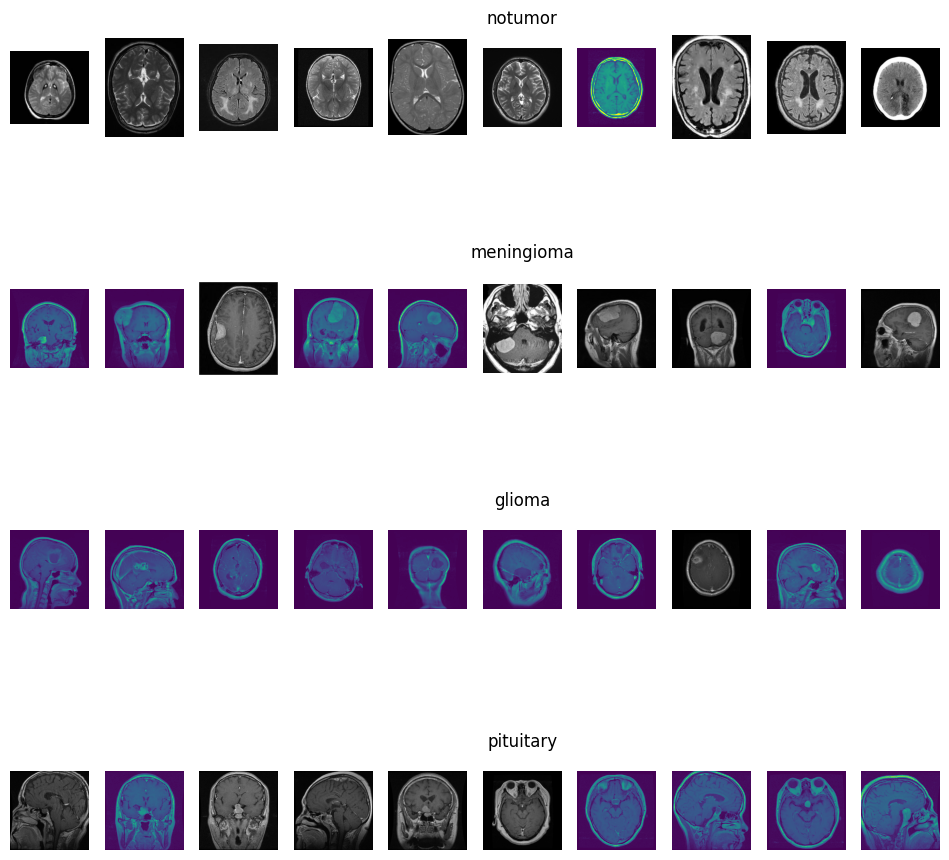

In [ ]:
plot_sample(label,IMG_PATH,10)

**CROPPING IMAGES**

In [ ]:
img = cv2.imread('/content/Brain Tumor Dataset/glioma/Te-glTr_0000.jpg')
# img = cv2.imread('/content/dataset-testing/glioma_tumor/image(1).jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

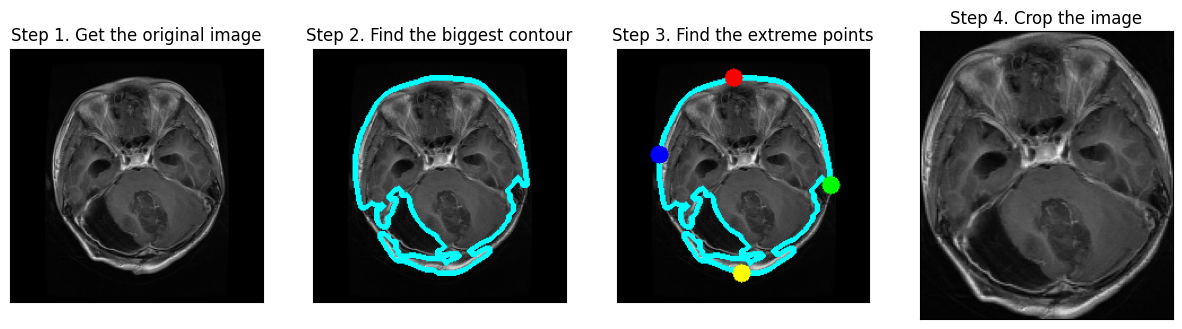

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
create_folder(CROPPED_IMG_PATH)

Folder '/content/Brain Tumor Dataset-cropped' created successfully.


In [ ]:
apply_crop(IMG_PATH,CROPPED_IMG_PATH)

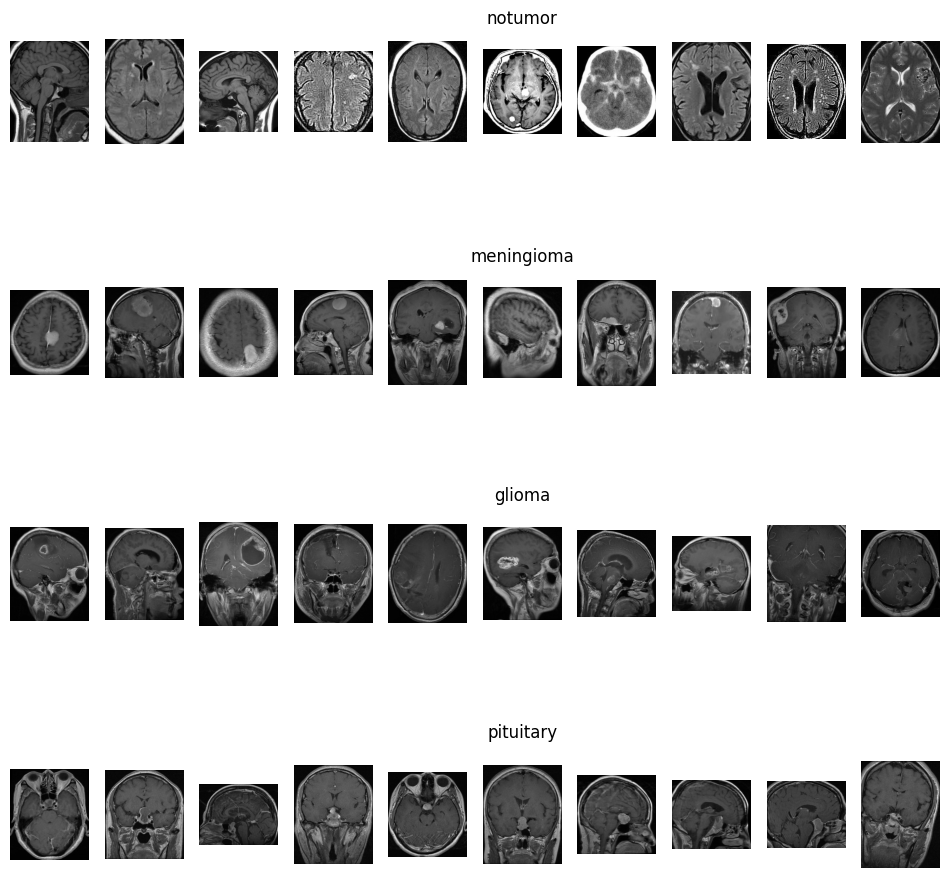

In [ ]:
plot_sample(label,CROPPED_IMG_PATH,10)

In [ ]:
create_folder(PROCCESS_IMG_PATH)

Folder '/content/Brain Tumor Dataset-proccess' created successfully.


In [ ]:
apply_preprocessing(CROPPED_IMG_PATH,PROCCESS_IMG_PATH,IMG_SIZE)

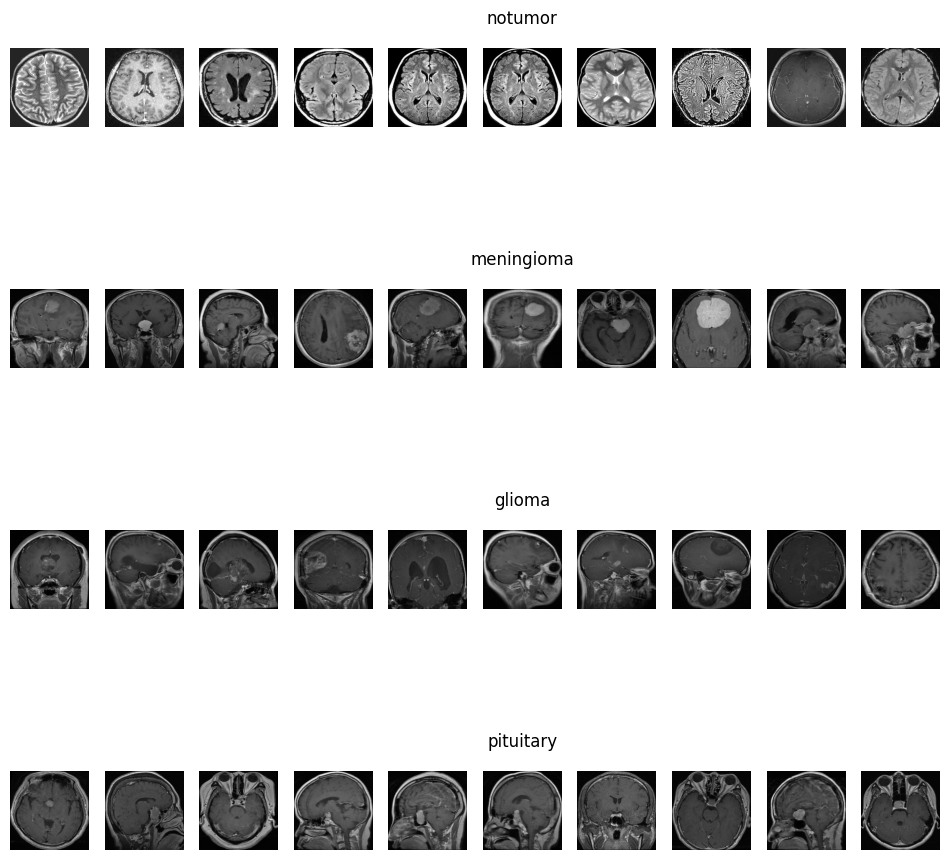

In [ ]:
plot_sample(label,PROCCESS_IMG_PATH,10)

**Augmentasi Data**

In [ ]:
demo_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    vertical_flip=True, 
    fill_mode='nearest')

In [ ]:
os.mkdir('preview')
x = cv2.imread('/content/Brain Tumor Dataset-proccess/glioma/Te-glTr_0000_cropped_0.jpg')  
# x = cv2.imread('/content/dataset-testing/glioma_tumor/image(1).jpg')  
x = np.expand_dims(x, axis=0)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

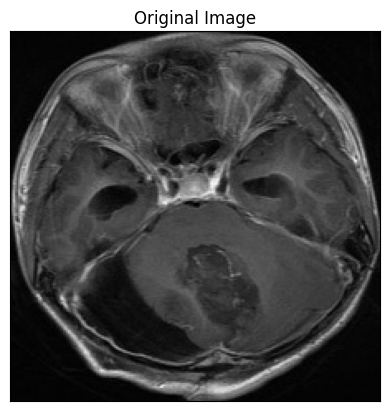

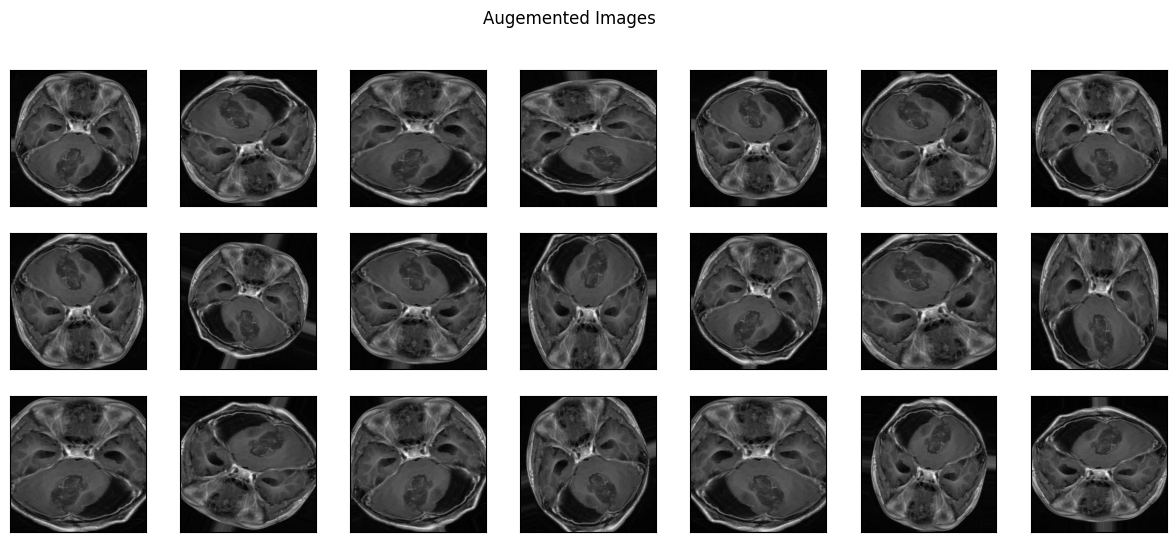

In [ ]:
plt.imshow(cv2.imread('/content/Brain Tumor Dataset-proccess/glioma/Te-glTr_0000_cropped_0.jpg')  )
# plt.imshow(cv2.imread('/content/dataset-testing/glioma_tumor/image(1).jpg')  )

plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [ ]:
!rm -rf preview/

# **Train Initial**

In [ ]:
# initial parameters
batchsize_initial = 64
epochs_initial = 50
dropout_value_initial = 0.2
optimizer_initial = 'Adam'
num_folds = 5


# tetsing
# batchsize_initial = 1
# epochs_initial = 1
# dropout_value_initial = 0.0
# optimizer_initial = 'Adam'
# num_folds = 2 


# constant parameters
targetsize_constant = (IMG_SIZE)
classmode_constant = 'categorical'

In [ ]:
# Buat list path gambar dan label pada dataset
image_paths = []
image_labels = []
for label_dir in os.listdir(PROCCESS_IMG_PATH):
    label = label_dir.lower()
    label_path = os.path.join(PROCCESS_IMG_PATH, label_dir)
    for image_file in os.listdir(label_path):
        image_path = os.path.join(label_path, image_file)
        image_paths.append(image_path)
        image_labels.append(label)

# # Ubah label menjadi array satu dimensi
# image_labels = np.ravel(image_labels)

# Buat dataframe berisi path gambar dan label
df = pd.DataFrame({'path': image_paths, 'label': image_labels})

print(df)

# Ubah tipe data kolom "label" menjadi string
df['label'] = df['label'].astype(str)

# Buat data generator
datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    vertical_flip=True, 
    fill_mode='nearest')
# Lakukan cross validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

                                                   path      label
0     /content/Brain Tumor Dataset-proccess/notumor/...    notumor
1     /content/Brain Tumor Dataset-proccess/notumor/...    notumor
2     /content/Brain Tumor Dataset-proccess/notumor/...    notumor
3     /content/Brain Tumor Dataset-proccess/notumor/...    notumor
4     /content/Brain Tumor Dataset-proccess/notumor/...    notumor
...                                                 ...        ...
7018  /content/Brain Tumor Dataset-proccess/pituitar...  pituitary
7019  /content/Brain Tumor Dataset-proccess/pituitar...  pituitary
7020  /content/Brain Tumor Dataset-proccess/pituitar...  pituitary
7021  /content/Brain Tumor Dataset-proccess/pituitar...  pituitary
7022  /content/Brain Tumor Dataset-proccess/pituitar...  pituitary

[7023 rows x 2 columns]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.regularizers import l1_l2

File train_df_fold1.pkl berhasil diupload ke folder /gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/
File val_df_fold1.pkl berhasil diupload ke folder /gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/
Found 5618 validated image filenames belonging to 4 classes.
Found 1405 validated image filenames belonging to 4 classes.
9406464/9406464 [==============================] - 2s 0us/step
Epoch 1/50
87/87 [==============================] - 124s 1s/step - loss: 1.2566 - accuracy: 0.6593 - val_loss: 0.9561 - val_accuracy: 0.8085
Epoch 2/50
87/87 [==============================] - 110s 1s/step - loss: 0.8824 - accuracy: 0.8012 - val_loss: 0.7872 - val_accuracy: 0.8555
Epoch 3/50
87/87 [==============================] - 111s 1s/step - loss: 0.8013 - accuracy: 0.8306 - val_loss: 0.7058 - val_accuracy: 0.8676
Epoch 4/50
87/87 [==============================] - 111s 1s/step - loss: 0.7549 - accuracy: 0.8525 - val_loss: 0.6658 - val_accuracy: 0.8797
Epoch 5/50
87/87 [=============================

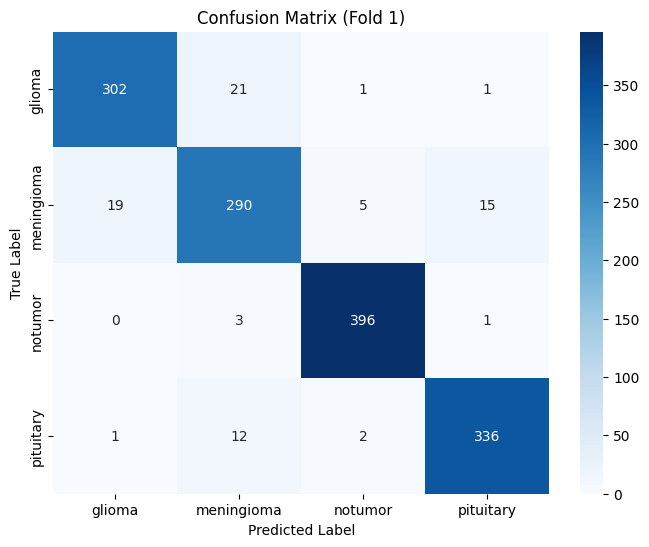

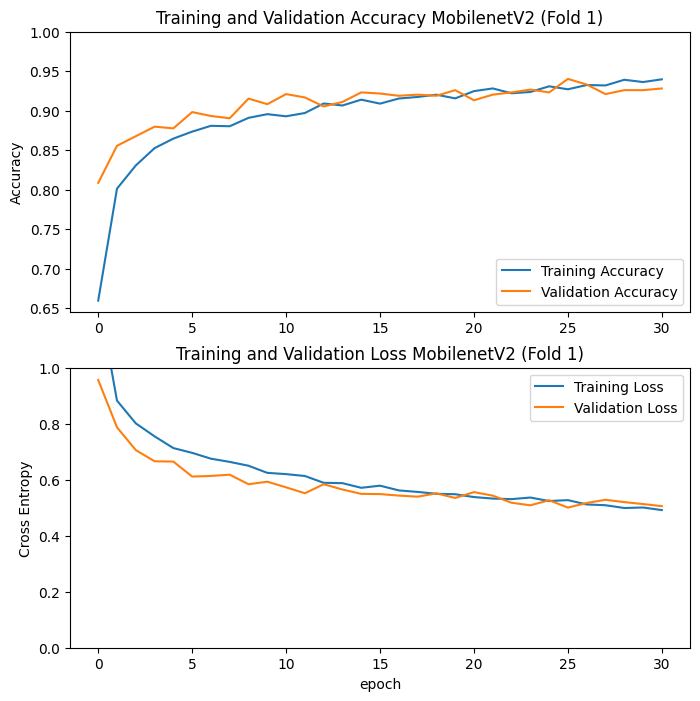

File fold_1_model.h5 berhasil diupload ke folder /gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/
File train_df_fold2.pkl berhasil diupload ke folder /gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/
File val_df_fold2.pkl berhasil diupload ke folder /gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/
Found 5618 validated image filenames belonging to 4 classes.
Found 1405 validated image filenames belonging to 4 classes.
Epoch 1/50
87/87 [==============================] - 117s 1s/step - loss: 1.2321 - accuracy: 0.6754 - val_loss: 0.9367 - val_accuracy: 0.8107
Epoch 2/50
87/87 [==============================] - 111s 1s/step - loss: 0.8823 - accuracy: 0.8019 - val_loss: 0.7559 - val_accuracy: 0.8619
Epoch 3/50
87/87 [==============================] - 111s 1s/step - loss: 0.8251 - accuracy: 0.8250 - val_loss: 0.7171 - val_accuracy: 0.8705
Epoch 4/50
87/87 [==============================] - 111s 1s/step - loss: 0.7558 - accuracy: 0.8504 - val_loss: 0.6696 - val_accuracy: 0.8897
Epoch 5/50

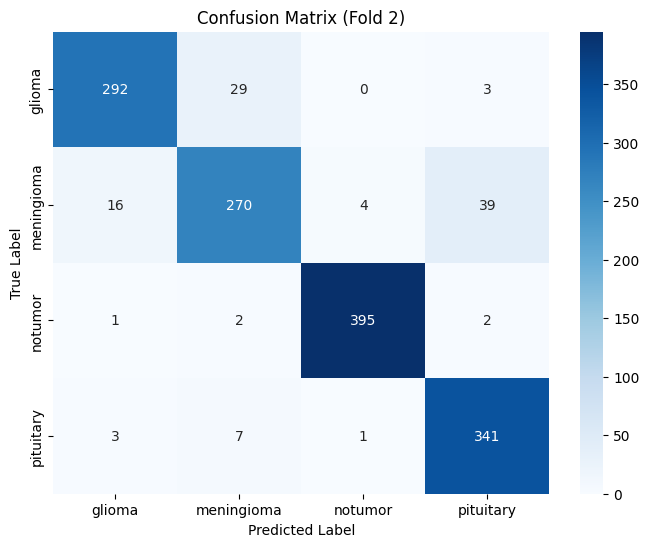

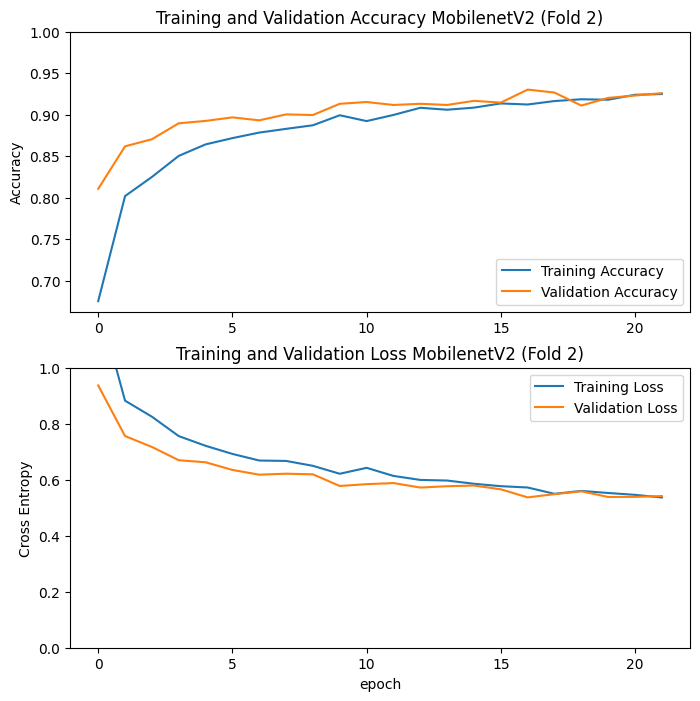

File fold_2_model.h5 berhasil diupload ke folder /gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/
File train_df_fold3.pkl berhasil diupload ke folder /gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/
File val_df_fold3.pkl berhasil diupload ke folder /gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/
Found 5618 validated image filenames belonging to 4 classes.
Found 1405 validated image filenames belonging to 4 classes.
Epoch 1/50
87/87 [==============================] - 104s 1s/step - loss: 1.2783 - accuracy: 0.6563 - val_loss: 0.9829 - val_accuracy: 0.7829
Epoch 2/50
87/87 [==============================] - 100s 1s/step - loss: 0.8926 - accuracy: 0.8055 - val_loss: 0.8038 - val_accuracy: 0.8427
Epoch 3/50
87/87 [==============================] - 101s 1s/step - loss: 0.8139 - accuracy: 0.8308 - val_loss: 0.7537 - val_accuracy: 0.8527
Epoch 4/50
87/87 [==============================] - 99s 1s/step - loss: 0.7605 - accuracy: 0.8529 - val_loss: 0.7231 - val_accuracy: 0.8712
Epoch 5/50


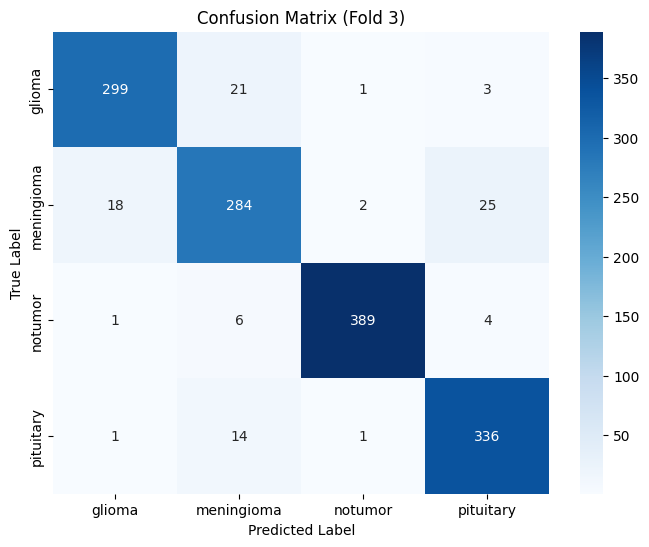

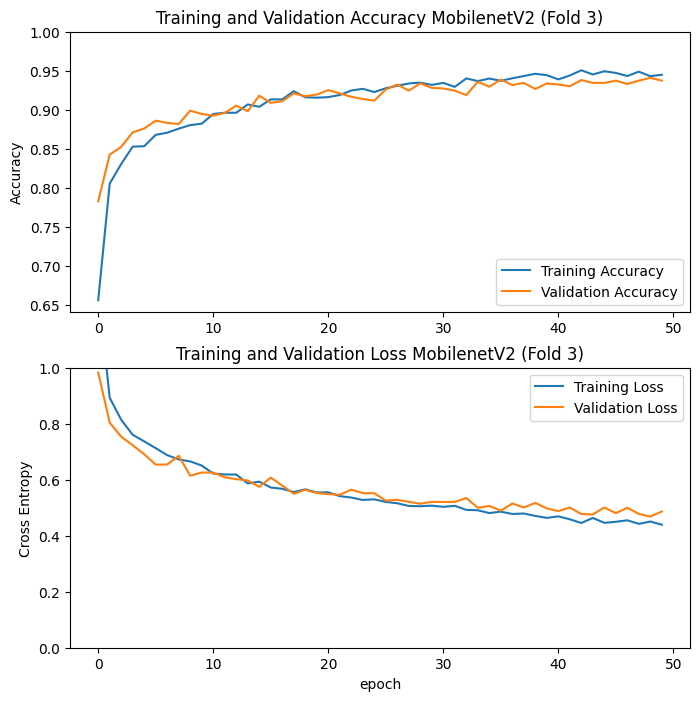

File fold_3_model.h5 berhasil diupload ke folder /gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/
File train_df_fold4.pkl berhasil diupload ke folder /gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/
File val_df_fold4.pkl berhasil diupload ke folder /gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/
Found 5619 validated image filenames belonging to 4 classes.
Found 1404 validated image filenames belonging to 4 classes.
Epoch 1/50
87/87 [==============================] - 106s 1s/step - loss: 1.2431 - accuracy: 0.6632 - val_loss: 0.9953 - val_accuracy: 0.7749
Epoch 2/50
87/87 [==============================] - 100s 1s/step - loss: 0.8875 - accuracy: 0.8004 - val_loss: 0.8049 - val_accuracy: 0.8397
Epoch 3/50
87/87 [==============================] - 99s 1s/step - loss: 0.8121 - accuracy: 0.8292 - val_loss: 0.7624 - val_accuracy: 0.8497
Epoch 4/50
87/87 [==============================] - 99s 1s/step - loss: 0.7669 - accuracy: 0.8463 - val_loss: 0.7043 - val_accuracy: 0.8625
Epoch 5/50
8

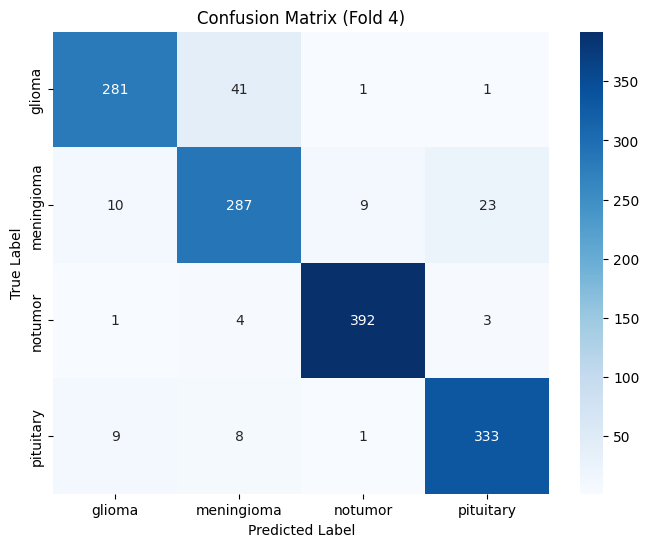

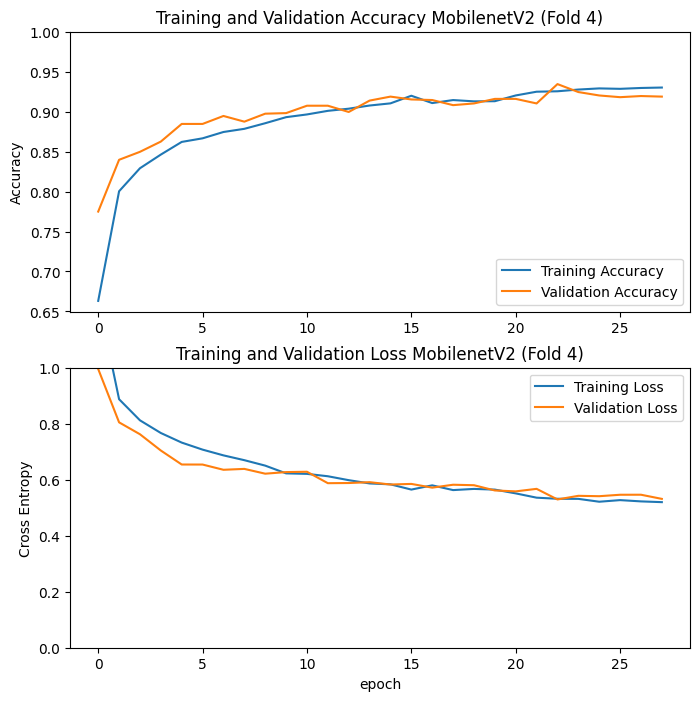

File fold_4_model.h5 berhasil diupload ke folder /gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/
File train_df_fold5.pkl berhasil diupload ke folder /gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/
File val_df_fold5.pkl berhasil diupload ke folder /gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/
Found 5619 validated image filenames belonging to 4 classes.
Found 1404 validated image filenames belonging to 4 classes.
Epoch 1/50
87/87 [==============================] - 106s 1s/step - loss: 1.2233 - accuracy: 0.6695 - val_loss: 0.9271 - val_accuracy: 0.8041
Epoch 2/50
87/87 [==============================] - 99s 1s/step - loss: 0.8770 - accuracy: 0.8038 - val_loss: 0.7678 - val_accuracy: 0.8618
Epoch 3/50
87/87 [==============================] - 99s 1s/step - loss: 0.8125 - accuracy: 0.8238 - val_loss: 0.7029 - val_accuracy: 0.8803
Epoch 4/50
87/87 [==============================] - 99s 1s/step - loss: 0.7645 - accuracy: 0.8403 - val_loss: 0.6810 - val_accuracy: 0.8718
Epoch 5/50
87

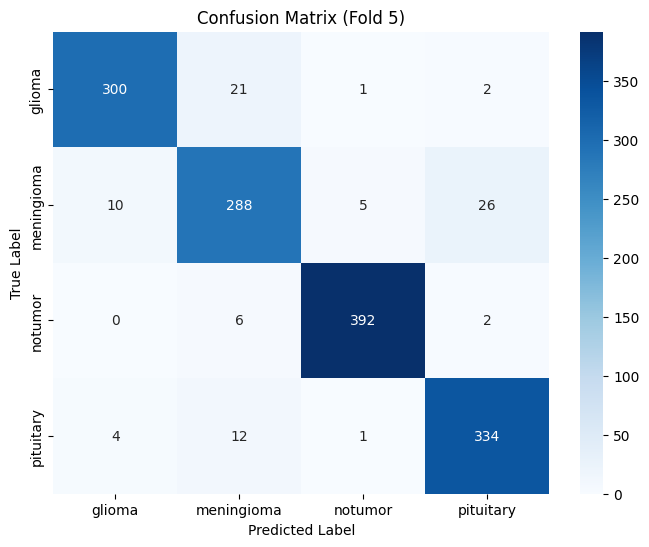

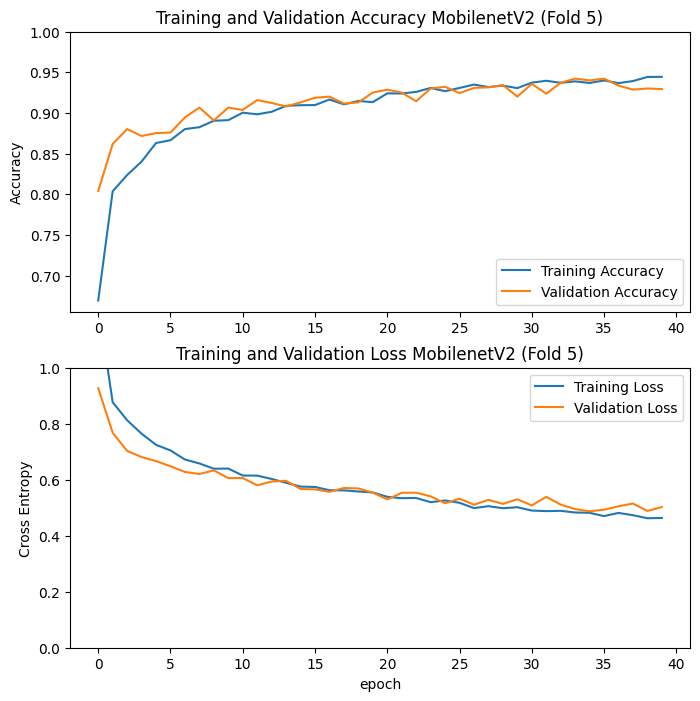

File fold_5_model.h5 berhasil diupload ke folder /gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/
Best Fold: 1
Best Sensitivity: 0.939488673265269


In [ ]:
results = []
results_class = []
best_sensitivity = 0
best_fold = 0

for fold, (train_index, val_index) in enumerate(skf.split(df['path'], df['label'])):
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index]

    # simpan train_df dan val_df di setiap foldnya
    with open(f'train_df_fold{fold+1}.pkl', 'wb') as f:
        pickle.dump(train_df, f)
    with open(f'val_df_fold{fold+1}.pkl', 'wb') as f:
        pickle.dump(val_df, f)

    upload_drive(f'train_df_fold{fold+1}.pkl',RESULT_FOLDER)
    upload_drive(f'val_df_fold{fold+1}.pkl',RESULT_FOLDER)


    image_size = [224,224] # choose image size

    train_generator_initial = datagen.flow_from_dataframe(dataframe=train_df,
                                                           x_col='path',
                                                           y_col='label',
                                                           color_mode='rgb',
                                                           batch_size=batchsize_initial,
                                                           class_mode="categorical",
                                                           shuffle=True)
    val_generator_initial = datagen.flow_from_dataframe(dataframe=val_df,
                                                         x_col='path',
                                                         y_col='label',
                                                         color_mode='rgb',
                                                         batch_size=batchsize_initial,
                                                         class_mode="categorical",
                                                         shuffle=True)

    # import the base model
    mobilenetv2_basemodel = MobileNetV2(input_shape=image_size + [3], weights='imagenet', include_top=False)

    # storing the base model in the kernel for later use to avoid loading many times
    base_model = mobilenetv2_basemodel

    # Freeze layer pada model
    for layer in base_model.layers:
        layer.trainable = False

    # Tambahkan layer klasifikasi pada model
    # add layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_value_initial)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_value_initial)(x)
    predictions = Dense(4, activation="softmax")(x)
    model = Model(inputs = base_model.input, outputs = predictions)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    # compile the model
    model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    tic = time.time()
    # Train model pada setiap fold
    step_size_train_initial=train_generator_initial.n//train_generator_initial.batch_size
    history = model.fit(train_generator_initial, epochs=epochs_initial,steps_per_epoch=step_size_train_initial, validation_data=val_generator_initial,callbacks=[early_stop])

    toc = time.time()

    # Evaluasi model pada validasi set
    val_generator = datagen.flow_from_dataframe(dataframe=val_df,
                                                x_col='path',
                                                y_col='label',
                                                color_mode='rgb',
                                                batch_size=batchsize_initial,
                                                class_mode="categorical",
                                                shuffle=False)
    scores = model.evaluate(val_generator)
    print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

    predictions = model.predict(val_generator)
    y_true = val_generator.labels
    y_pred = np.argmax(predictions, axis=1)

    # hitung confusion matrix dan hasil evaluasi per kelas
    cm = confusion_matrix(y_true, y_pred)
    class_names = train_generator_initial.class_indices.keys()
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

     # hitung specificity 
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    specificity = []
    for i in range(len(class_names)):
        spec = tn / (tn + fp)
        specificity.append(spec)

    # tampilkan confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix (Fold {fold+1})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    sensitivity_ava = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    time_taken = toc - tic

    if fold == 0:
      best_sensitivity = sensitivity_ava
      best_fold = fold+1
    elif best_sensitivity < sensitivity_ava:
      best_sensitivity = sensitivity_ava
      best_fold = fold+1

    # tampilkan hasil evaluasi per kelas
    for i, name in enumerate(class_names):
        results_class.append({'fold': fold+1, 'class': name,'accuracy': accuracy,'precision': report[name]['precision'],
                                  'sensitivity': report[name]['recall'], 'specificity': specificity[i],
                                   'f1-score': report[name]['f1-score'], 'time_taken': time_taken/60.0})

    results.append({'fold':fold+1,
                'accuracy': accuracy,
                'precision': precision,
                'sensitivity': sensitivity_ava,
                'specificity': np.mean(specificity),
                'f1-score': f1,
                'time_taken': time_taken/60.0})

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(f'Training and Validation Accuracy MobilenetV2 (Fold {fold+1})')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title(f'Training and Validation Loss MobilenetV2 (Fold {fold+1})')
    plt.xlabel('epoch')
    plt.show()
    

    model.save(f'fold_{fold+1}_model.h5')
    upload_drive(f'fold_{fold+1}_model.h5',RESULT_FOLDER)

# Konversi list results ke dalam dataframe pandas
df_results = pd.DataFrame(results, columns=['fold', 'accuracy','precision', 'sensitivity','specificity', 'f1-score', 'time_taken'])
df_results_class = pd.DataFrame(results_class, columns=['fold', 'class','accuracy', 'precision','sensitivity', 'specificity', 'f1-score', 'time_taken'])
# Tampilkan hasil evaluasi dalam bentuk tabel
pd.DataFrame(df_results)
pd.DataFrame(df_results_class)
print('Best Fold:',best_fold)
print('Best Sensitivity:',best_sensitivity)

In [ ]:
print('Avarage:')
df_results

Avarage:


,fold,accuracy,precision,sensitivity,specificity,f1-score,time_taken
0,1,0.942349,0.939875,0.939489,0.934985,0.939664,56.364523
1,2,0.923843,0.921434,0.919538,0.909657,0.919709,40.579761
2,3,0.930961,0.928504,0.928277,0.934375,0.928234,87.807045
3,4,0.920940,0.918844,0.917086,0.872671,0.917561,49.415367
4,5,0.935897,0.934047,0.933218,0.934579,0.933495,75.579487


In [ ]:
pd.DataFrame(df_results_class)
print('Class:')
df_results_class

Class:


,fold,class,accuracy,precision,sensitivity,specificity,f1-score,time_taken
0,1,glioma,0.942349,0.937888,0.929231,0.934985,0.933539,56.364523
1,1,meningioma,0.942349,0.889571,0.881459,0.934985,0.885496,56.364523
2,1,notumor,0.942349,0.980198,0.990000,0.934985,0.985075,56.364523
3,1,pituitary,0.942349,0.951841,0.957265,0.934985,0.954545,56.364523
4,2,glioma,0.923843,0.935897,0.901235,0.909657,0.918239,40.579761
5,2,meningioma,0.923843,0.876623,0.820669,0.909657,0.847724,40.579761
6,2,notumor,0.923843,0.987500,0.987500,0.909657,0.987500,40.579761
7,2,pituitary,0.923843,0.885714,0.968750,0.909657,0.925373,40.579761
8,3,glioma,0.930961,0.937304,0.922840,0.934375,0.930016,87.807045
9,3,meningioma,0.930961,0.873846,0.863222,0.934375,0.868502,87.807045


# **Section two:** We will start fine tunning

In [ ]:
model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

model.summary()

Number of layers in the base model:  162
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                  

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5) #PASTIKAN MENGGUNAKAN OPTIMIZER TERBAIK
# compile the model
model.compile(optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])


In [ ]:
fine_tune_epochs = 10 #GANTI JIKA BUKAN TESTINg
total_epochs =  epochs_initial + fine_tune_epochs

history_fine = model.fit(train_generator_initial,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_generator_initial,callbacks=[early_stop])

Epoch 40/60
88/88 [==============================] - 119s 1s/step - loss: 0.5959 - accuracy: 0.8973 - val_loss: 0.7114 - val_accuracy: 0.8789
Epoch 41/60
88/88 [==============================] - 103s 1s/step - loss: 0.5876 - accuracy: 0.9027 - val_loss: 0.6424 - val_accuracy: 0.9017
Epoch 42/60
88/88 [==============================] - 101s 1s/step - loss: 0.5617 - accuracy: 0.9078 - val_loss: 0.6343 - val_accuracy: 0.8889
Epoch 43/60
88/88 [==============================] - 103s 1s/step - loss: 0.5401 - accuracy: 0.9121 - val_loss: 0.5985 - val_accuracy: 0.9081
Epoch 44/60
88/88 [==============================] - 104s 1s/step - loss: 0.5280 - accuracy: 0.9194 - val_loss: 0.5668 - val_accuracy: 0.9103
Epoch 45/60
88/88 [==============================] - 102s 1s/step - loss: 0.5230 - accuracy: 0.9235 - val_loss: 0.5591 - val_accuracy: 0.9103
Epoch 46/60
88/88 [==============================] - 104s 1s/step - loss: 0.5171 - accuracy: 0.9229 - val_loss: 0.5644 - val_accuracy: 0.9110
Epoch 

Found 1405 validated image filenames belonging to 4 classes.
22/22 [==============================] - 21s 912ms/step


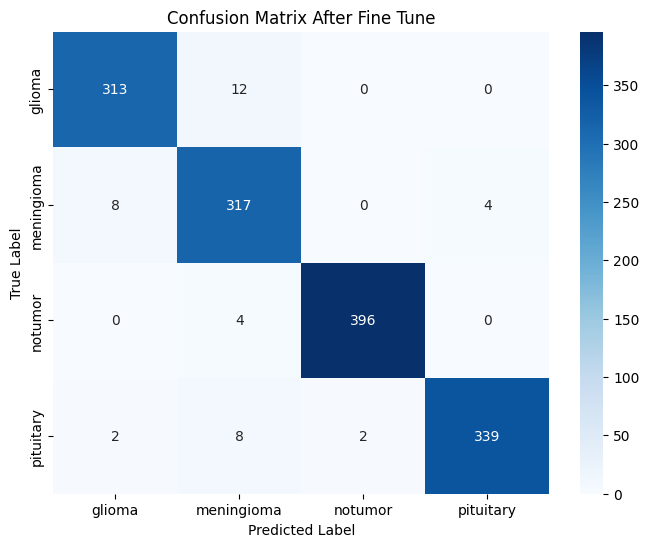

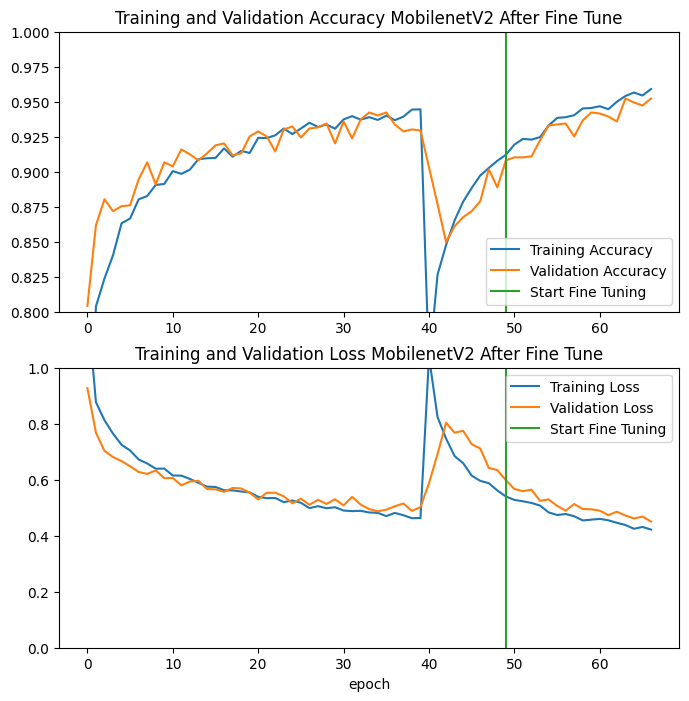

Avarage:


,accuracy,precision,sensitivity,specificity,f1-score,time_taken
0,0.97153,0.970493,0.970604,0.963077,0.970436,144.405019


In [ ]:
results_fine = []
results_class_fine = []

toc = time.time()

with open(f'val_df_fold{best_fold}.pkl', 'rb') as f:
    val_df_fine = pickle.load(f)

# Evaluasi model pada validasi set
val_generator = datagen.flow_from_dataframe(dataframe=val_df_fine,
                                        x_col='path',
                                        y_col='label',
                                        color_mode='rgb',
                                        batch_size=batchsize_initial,
                                        class_mode="categorical",
                                        shuffle=False)

predictions = model.predict(val_generator)
y_true = val_generator.labels
y_pred = np.argmax(predictions, axis=1)

# hitung confusion matrix dan hasil evaluasi per kelas
cm = confusion_matrix(y_true, y_pred)
class_names = train_generator_initial.class_indices.keys()
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# hitung specificity 
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
specificity = []
for i in range(len(class_names)):
    spec = tn / (tn + fp)
    specificity.append(spec)

# tampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix After Fine Tune')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
sensitivity_ava = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
time_taken = toc - tic

# tampilkan hasil evaluasi per kelas
for i, name in enumerate(class_names):
    results_class_fine.append({'class': name,'accuracy': accuracy,'precision': report[name]['precision'],
                              'sensitivity': report[name]['recall'], 'specificity': specificity[i],
                                'f1-score': report[name]['f1-score'], 'time_taken': time_taken/60.0})

results_fine.append({'accuracy': accuracy,
            'precision': precision,
            'sensitivity': sensitivity_ava,
            'specificity': np.mean(specificity),  # menambahkan rata-rata specificity untuk setiap kelas
            'f1-score': f1,
            'time_taken': time_taken/60.0})

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs_initial-1,epochs_initial-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy MobilenetV2 After Fine Tune')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs_initial-1,epochs_initial-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss MobilenetV2 After Fine Tune')
plt.xlabel('epoch')
plt.show()

# Konversi list results ke dalam dataframe pandas
df_results_fine = pd.DataFrame(results_fine, columns=['accuracy','precision', 'sensitivity','specificity', 'f1-score', 'time_taken'])
df_results_class_fine = pd.DataFrame(results_class_fine, columns=['class','accuracy', 'precision','sensitivity', 'specificity', 'f1-score', 'time_taken'])
# Tampilkan hasil evaluasi dalam bentuk tabel
pd.DataFrame(df_results_fine)
pd.DataFrame(df_results_class_fine)
print('Avarage:')
df_results_fine

In [ ]:
# evaluation on validation data
scores = model.evaluate(val_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

22/22 [==============================] - 20s 914ms/step - loss: 0.3779 - accuracy: 0.9779
evaluate accuracy: 97.79%


In [ ]:
pd.DataFrame(df_results_class_fine)
print('Class:')
df_results_class_fine

Class:


,class,accuracy,precision,sensitivity,specificity,f1-score,time_taken
0,glioma,0.97153,0.969040,0.963077,0.963077,0.966049,144.405019
1,meningioma,0.97153,0.929619,0.963526,0.963077,0.946269,144.405019
2,notumor,0.97153,0.994975,0.990000,0.963077,0.992481,144.405019
3,pituitary,0.97153,0.988338,0.965812,0.963077,0.976945,144.405019


In [ ]:
model.save(f'model_MobilenetV2_final.h5')
upload_drive(f'model_MobilenetV2_final.h5',RESULT_FOLDER)

File model_MobilenetV2_final.h5 berhasil diupload ke folder /gdrive/My Drive/SKRIPSI/Result/MobilenetV2_Coba3/


In [ ]:
df_results_class

,fold,class,accuracy,precision,sensitivity,specificity,f1-score,time_taken
0,1,glioma,0.942349,0.937888,0.929231,0.934985,0.933539,56.364523
1,1,meningioma,0.942349,0.889571,0.881459,0.934985,0.885496,56.364523
2,1,notumor,0.942349,0.980198,0.990000,0.934985,0.985075,56.364523
3,1,pituitary,0.942349,0.951841,0.957265,0.934985,0.954545,56.364523
4,2,glioma,0.923843,0.935897,0.901235,0.909657,0.918239,40.579761
5,2,meningioma,0.923843,0.876623,0.820669,0.909657,0.847724,40.579761
6,2,notumor,0.923843,0.987500,0.987500,0.909657,0.987500,40.579761
7,2,pituitary,0.923843,0.885714,0.968750,0.909657,0.925373,40.579761
8,3,glioma,0.930961,0.937304,0.922840,0.934375,0.930016,87.807045
9,3,meningioma,0.930961,0.873846,0.863222,0.934375,0.868502,87.807045


In [ ]:
df_results_class_fine

,class,accuracy,precision,sensitivity,specificity,f1-score,time_taken
0,glioma,0.97153,0.969040,0.963077,0.963077,0.966049,144.405019
1,meningioma,0.97153,0.929619,0.963526,0.963077,0.946269,144.405019
2,notumor,0.97153,0.994975,0.990000,0.963077,0.992481,144.405019
3,pituitary,0.97153,0.988338,0.965812,0.963077,0.976945,144.405019


# PREDICT

In [ ]:
# Load the trained model
model = tf.keras.models.load_model('model_MobilenetV2_final.h5')

# Define the classes
classes = ['0', '1', '2','3']

# Preprocess the input data
def preprocess_input(img):
    # Resize the input image to match the model's input size
    img = cv2.resize(img, (224, 224))
    # Convert the input image to a float32 array and normalize its pixel values
    img = img.astype(np.float32) / 255.0
    # Add an extra dimension to the input to match the model's input shape
    img = np.expand_dims(img, axis=0)
    return img

# Load the input image
# img_path = '/content/dataset-testing-proccess/no_tumor/image(1)_cropped_0.jpg'
img_path = '/content/Brain Tumor Dataset/glioma/Te-glTr_0000.jpg'
img = cv2.imread(img_path)

# Preprocess the input image
img = preprocess_input(img)

# Predict the class probabilities for the input image
probs = model.predict(img)[0]

# Convert the probabilities to a predicted class label
predicted_class = classes[np.argmax(probs)]

# Print the predicted class label and probabilities for all classes
print('Predicted class:', predicted_class)
print('Class probabilities:', dict(zip(classes, probs)))

1/1 [==============================] - 1s 1s/step
Predicted class: 0
Class probabilities: {'0': 0.9999839, '1': 1.1795566e-05, '2': 4.3390028e-06, '3': 5.0215343e-09}


1/1 [==============================] - 1s 783ms/step


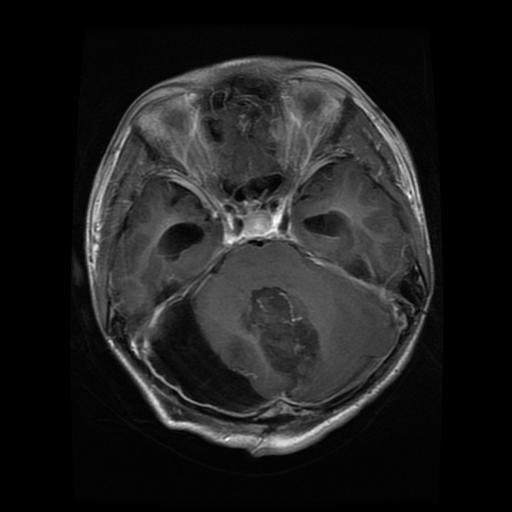

-1

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab.patches import cv2_imshow

# Load the saved model
model = load_model('model_MobilenetV2_final.h5')

# Load the image and preprocess it
# img_path = '/content/dataset-testing-proccess/no_tumor/image(1)_cropped_0.jpg'
img_path = '/content/Brain Tumor Dataset/glioma/Te-glTr_0000.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.

# Predict the segmentation mask for the image
pred_mask = model.predict(x)[0]
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = np.expand_dims(pred_mask, axis=-1)

# Resize the mask to the original image size
orig_img = cv2.imread(img_path)
mask = cv2.resize(pred_mask, (orig_img.shape[1], orig_img.shape[0]), interpolation=cv2.INTER_NEAREST)
mask = np.squeeze(mask)

# Threshold the mask to get the tumor region
threshold = 0.5
mask = np.where(mask > threshold, 1, 0)

# Find the contours of the tumor region
contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
output_img = orig_img.copy()
for cnt in contours:
    cv2.drawContours(output_img, [cnt], 0, (0, 255, 0), 2)

# Display the output image with contours
cv2_imshow(output_img)
cv2.waitKey(0)